In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('aircraft-data_nov_dec.csv')
df.head()

,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/24,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/22 13:30
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/24,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/22 13:30
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/24,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/22 13:30
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/24,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/22 13:30
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/24,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/22 13:40


In [5]:
# Timestamp preprocessing and sort
print("[INFO] Preprocessing timestamps and sorting by time...")
df['spotted'] = pd.to_datetime(df['spotted'])
df = df.sort_values(by=['flight', 'spotted'])

# Rate of change features
print("[INFO] Calculating rate of change features...")
df['alt_rate'] = df.groupby('flight')['alt'].diff() / df.groupby('flight')['spotted'].diff().dt.total_seconds()
df['mph_rate'] = df.groupby('flight')['mph'].diff() / df.groupby('flight')['spotted'].diff().dt.total_seconds()

# Smoothing (optional but helps a lot)
df['alt_rate_smooth'] = df.groupby('flight')['alt_rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['mph_rate_smooth'] = df.groupby('flight')['mph_rate'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Fill NaNs
df = df.fillna(0)

[INFO] Preprocessing timestamps and sorting by time...
[INFO] Calculating rate of change features...


In [6]:
# Phase labeling (tune thresholds if needed)
print("[INFO] Labeling flight phases...")
def label_phase(row):
    if row['alt_rate_smooth'] > 1.0:
        return "Climb"
    elif row['alt_rate_smooth'] < -1.0:
        return "Descent"
    else:
        return "Cruise"
df['phase'] = df.apply(label_phase, axis=1)

# Features and target
features = ['alt', 'mph', 'alt_rate_smooth', 'mph_rate_smooth']
X = df[features]
y = df['phase']

[INFO] Labeling flight phases...


[INFO] Scaling features...
[INFO] Training classifier...
[INFO] Evaluating model...

Classification Report:
              precision    recall  f1-score   support

       Climb       0.99      1.00      1.00       114
      Cruise       1.00      1.00      1.00      6019
     Descent       1.00      1.00      1.00        57

    accuracy                           1.00      6190
   macro avg       1.00      1.00      1.00      6190
weighted avg       1.00      1.00      1.00      6190



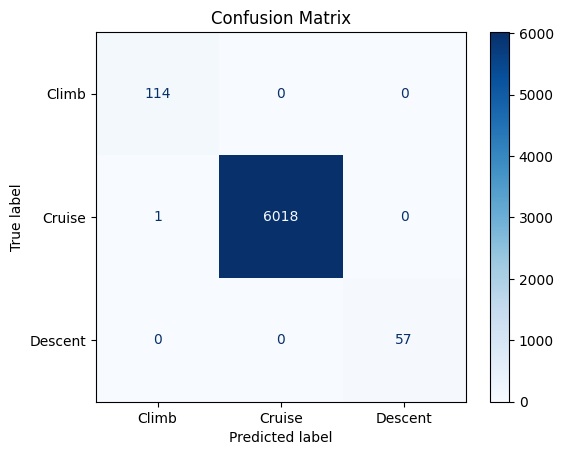

In [7]:
# Scale
print("[INFO] Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train
print("[INFO] Training classifier...")
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("[INFO] Evaluating model...")
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

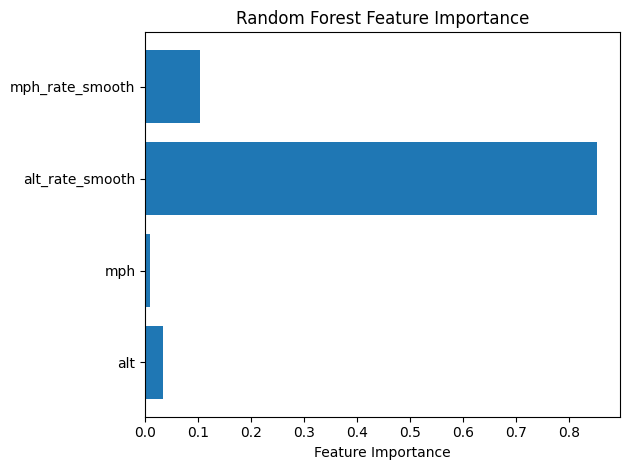

In [8]:
# Feature importances
importances = clf.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


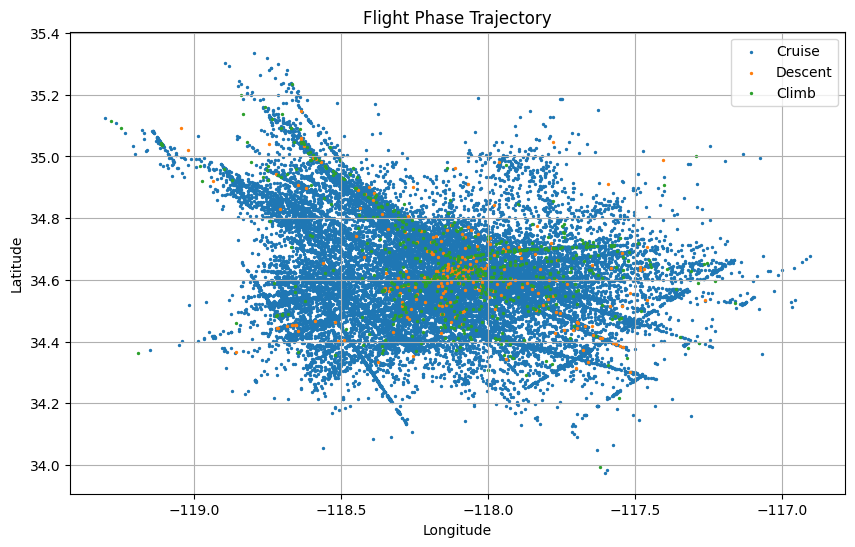

In [9]:
plt.figure(figsize=(10, 6))
for phase in df['phase'].unique():
    subset = df[df['phase'] == phase]
    plt.scatter(subset['long'], subset['lat'], s=2, label=phase)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Flight Phase Trajectory")
plt.grid(True)
plt.show()


In [10]:
import joblib
joblib.dump(clf, 'flight_phase_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']